In [40]:
import pandas as pd
import numpy as np
import os

from string import digits, punctuation
import re
import spacy
import dill

import xml.etree.ElementTree as ET

from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

Dataset for Computational Medicine Center's 2007 Medical Natural Language Processing Challenge
http://www.people.vcu.edu/~btmcinnes/projects/icd9cm.html

Part of the xml file:

# Preprocessing the dataset from the competition

In [41]:
docs = ET.parse('2007ChallengeTrainData.xml')
doc_list = docs.findall('doc')
len(doc_list)

978

In [42]:
ID = []
CMC_MAJORITY = []
CLINICAL_HISTORY = []
IMPRESSION = []

for doc in doc_list:
    ID.append(doc.get('id'))
    
    codes = [ code.text for code in doc[0] if code.get('origin') == "CMC_MAJORITY"]
    CMC_MAJORITY.append(codes)
    
    CLINICAL_HISTORY.append(doc[1][0].text)
    IMPRESSION.append(doc[1][1].text)
    
data = {#'ID': ID, 
        'CLINICAL_HISTORY': CLINICAL_HISTORY, 
        'IMPRESSION':IMPRESSION, 
        'ICD9_CM':CMC_MAJORITY}

#df = pd.DataFrame(data).set_index('ID')
df = pd.DataFrame(data, index=ID)
df.head()

,CLINICAL_HISTORY,ICD9_CM,IMPRESSION
97636670,"Eleven year old with ALL, bone marrow transpla...",[786.2],1. No focal pneumonia. Likely chronic changes ...
97638013,Six year old with history of cough for one week.,[786.2],The lungs are clear. Question prominent hilar ...
97638202,Four month old with history of cough.,[786.2],No radiographic abnormality seen of the chest.
97639641,Sixteen and a half year old male with history ...,[786.2],Normal chest x-ray. Please see above findings.
97639724,"Cough, tachypnea.",[786.2],1. Right middle lobe atelectasis vs pneumonia....


In [43]:
#number of unique codes appeared:
codes = []
for code in df['ICD9_CM']:
    codes = codes + code
unique_codes = set(codes)
len(unique_codes)

45

In [44]:
#number of unique combinations of codes appeared:
combinations = []
for code in df['ICD9_CM']:
    if code not in combinations:
        combinations.append(code)
len(combinations)

94

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 97636670 to 99670587
Data columns (total 3 columns):
CLINICAL_HISTORY    978 non-null object
ICD9_CM             978 non-null object
IMPRESSION          978 non-null object
dtypes: object(3)
memory usage: 30.6+ KB


In [46]:
df['CLINICAL_HISTORY'][0]

'Eleven year old with ALL, bone marrow transplant on Jan. 2, now with three day history of cough.'

In [47]:
df['IMPRESSION'][0]

'1. No focal pneumonia. Likely chronic changes at the left lung base. 2. Mild anterior wedging of the thoracic vertebral bodies.'

In [48]:
# Combine CLINICAL_HISTORY with IMPRESSION
df['CLINICAL_HISTORY_IMPRESSION'] = df['CLINICAL_HISTORY'] + ' ' + df['IMPRESSION']

In [49]:
df.head()

,CLINICAL_HISTORY,ICD9_CM,IMPRESSION,CLINICAL_HISTORY_IMPRESSION
97636670,"Eleven year old with ALL, bone marrow transpla...",[786.2],1. No focal pneumonia. Likely chronic changes ...,"Eleven year old with ALL, bone marrow transpla..."
97638013,Six year old with history of cough for one week.,[786.2],The lungs are clear. Question prominent hilar ...,Six year old with history of cough for one wee...
97638202,Four month old with history of cough.,[786.2],No radiographic abnormality seen of the chest.,Four month old with history of cough. No radio...
97639641,Sixteen and a half year old male with history ...,[786.2],Normal chest x-ray. Please see above findings.,Sixteen and a half year old male with history ...
97639724,"Cough, tachypnea.",[786.2],1. Right middle lobe atelectasis vs pneumonia....,"Cough, tachypnea. 1. Right middle lobe atelect..."


In [50]:
df['CLINICAL_HISTORY_IMPRESSION'][0]

'Eleven year old with ALL, bone marrow transplant on Jan. 2, now with three day history of cough. 1. No focal pneumonia. Likely chronic changes at the left lung base. 2. Mild anterior wedging of the thoracic vertebral bodies.'

In [51]:
for code in unique_codes:
    df['ICD9_'+code] = df['ICD9_CM'].apply(lambda x: 1 if code in x else 0)

In [52]:
df.head()

,CLINICAL_HISTORY,ICD9_CM,IMPRESSION,CLINICAL_HISTORY_IMPRESSION,ICD9_785.6,ICD9_599.0,ICD9_789.00,ICD9_V67.09,ICD9_462,ICD9_786.50,...,ICD9_596.54,ICD9_753.21,ICD9_789.09,ICD9_786.59,ICD9_795.5,ICD9_783.0,ICD9_753.3,ICD9_596.8,ICD9_486,ICD9_780.6
97636670,"Eleven year old with ALL, bone marrow transpla...",[786.2],1. No focal pneumonia. Likely chronic changes ...,"Eleven year old with ALL, bone marrow transpla...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97638013,Six year old with history of cough for one week.,[786.2],The lungs are clear. Question prominent hilar ...,Six year old with history of cough for one wee...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97638202,Four month old with history of cough.,[786.2],No radiographic abnormality seen of the chest.,Four month old with history of cough. No radio...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97639641,Sixteen and a half year old male with history ...,[786.2],Normal chest x-ray. Please see above findings.,Sixteen and a half year old male with history ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97639724,"Cough, tachypnea.",[786.2],1. Right middle lobe atelectasis vs pneumonia....,"Cough, tachypnea. 1. Right middle lobe atelect...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train, Test Split

In [53]:
y_columns = list(df.columns[4:])
len(y_columns)

45

In [54]:
X = df['CLINICAL_HISTORY_IMPRESSION']
Y = df[y_columns]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [55]:
type(X_train)

pandas.core.series.Series

In [56]:
X_train.head()

97716758    Nine - month-old female, status post cardiac a...
99646646    2-year - old female with grade 1/2 bilateral v...
97683176    4-year 5-month - old male with cough of 10 day...
97682157    8-month-13-day - old male with cough. Evaluate...
97643664               Reactive PPD. Normal chest radiograph.
Name: CLINICAL_HISTORY_IMPRESSION, dtype: object

In [57]:
type(Y_train)

pandas.core.frame.DataFrame

# Tokenize with SpaCy

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [21]:
# Showing a record with ' 1-1/2-year' in it
for i, row in zip(X.index, X):
    if ' 1-1/2-year' in row:
        index = i
        print('index:', index)
        print(row)        
        break

index: 99631757
Followup on a 1-1/2-year - old with caudal regression and neurogenic bladder. Bilateral renal growth and mild bilateral hydronephrosis which has decreased on the left.


In [378]:
# nlp = spacy.load('en')
    
# def words2tokens(row, nlp):
#     """tokenize each word and for each tocken:
#     1. excludes digits and punctuations, 
#     2. excludes token that has '-year', 
#     3. excludes stop words,
#     4. makes the token stemmed,
#     and return a string with all tokens separated by a space"""
#     stop_words = list(ENGLISH_STOP_WORDS)
#     custom_stop = ['year', 'month', 'old']
#     stop = stop_words + custom_stop
#     stemmer = PorterStemmer()
    
#     l = []    
#     doc = nlp(row)
#     for token in doc:
#         t = token.text.lower()
#         if (t in punctuation) or t.isdigit():
#             continue
#         if ('-year' in t) or ('-month' in t) or ('-day' in t):
#             continue
#         if ('/' in t) or ('=' in t) or (t in stop):
#             continue
#         l.append(stemmer.stem(t))
#     return ' '.join(l)

In [282]:
def tokenization(df=None):
    """tokenize each word and for each tocken:
    1. excludes digits and punctuations, 
    2. excludes token that has '-year', 
    3. excludes stop words,
    4. makes the token stemmed,
    and return a string with all tokens separated by a space"""
    nlp = spacy.load('en')
    stop_words = list(ENGLISH_STOP_WORDS)
    custom_stop = ['year', 'month', 'old']
    stop = stop_words + custom_stop
    stemmer = PorterStemmer()
    
    def words2tokens(sentence, nlp, stop, stemmer):
        l = []    
        tokens = nlp(sentence)
        for token in tokens:
            t = token.text.lower()
            if (t in punctuation) or t.isdigit():
                continue
            if ('-year' in t) or ('-month' in t) or ('-day' in t):
                continue
            if ('/' in t) or ('=' in t) or (t in stop):
                continue
            l.append(stemmer.stem(t))
        return ' '.join(l)
    
    Series = df.apply(lambda x: words2tokens(x, nlp, stop, stemmer))    
    return Series

In [283]:
tokenizer = FunctionTransformer(tokenization, validate=False)

In [284]:
X_train_token = tokenization(df=X_train)
X_test_token = tokenization(df=X_test)
# Showing the same record after tokenization
X_test_token.loc[index]

'followup caudal regress neurogen bladder bilater renal growth mild bilater hydronephrosi decreas left'

In [285]:
X_train_token.head()

97716758    femal statu post cardiac arrest persist pulmon...
99646646    femal grade bilater vesicoureter reflux determ...
97683176    male cough day durat fever rule pneumonia scat...
97682157    male cough evalu pneumonia possibl right lower...
97643664                  reactiv ppd normal chest radiograph
Name: CLINICAL_HISTORY_IMPRESSION, dtype: object

In [286]:
# check most frequent words
unique_token = X_train_token.str.split(expand=True).stack().value_counts()
for token, row in zip(unique_token.index, unique_token):
    print(token, '\t', row)

normal 	 449
kidney 	 291
cough 	 262
right 	 258
left 	 252
pneumonia 	 235
renal 	 216
bladder 	 176
ultrasound 	 167
chest 	 163
fever 	 153
femal 	 153
histori 	 152
patient 	 152
interv 	 131
growth 	 121
male 	 107
infect 	 106
reflux 	 106
hydronephrosi 	 105
mild 	 105
urinari 	 104
lobe 	 104
appear 	 103
tract 	 94
diseas 	 94
bilater 	 90
focal 	 83
lower 	 79
lung 	 77
followup 	 72
airway 	 64
upper 	 60
seen 	 59
includ 	 58
radiograph 	 56
vesicoureter 	 55
find 	 55
pain 	 55
reactiv 	 54
viral 	 53
atelectasi 	 53
thicken 	 52
day 	 52
evid 	 51
post 	 49
's 	 49
studi 	 49
evalu 	 48
neurogen 	 46
grade 	 46
statu 	 45
size 	 43
prior 	 43
stabl 	 42
abnorm 	 41
suggest 	 41
x 	 40
pole 	 40
week 	 39
minim 	 38
clear 	 38
small 	 38
chang 	 38
wheez 	 38
repres 	 36
uti 	 36
like 	 35
increas 	 35
opac 	 34
moder 	 33
pyelectasi 	 32
hematuria 	 32
scar 	 32
dilat 	 31
consist 	 31
infiltr 	 31
deflux 	 30
ureter 	 30
follow 	 29
acut 	 29
examin 	 29
signific 	 27
j

In [249]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=3000)
tfidf.fit(X_train_token)
train_tv = tfidf.transform(X_train_token)
test_tv = tfidf.transform(X_test_token)

df_train_tv = pd.DataFrame(train_tv.todense(), 
                           columns=[x for x in tfidf.get_feature_names()], 
                           index=X_train_token.index)
df_train_tv.head()
# df_test_tv = pd.DataFrame(test_tv.todense(), 
#                           columns=[x for x in tfidf.get_feature_names()], 
#                           index=X_test_token.index)    

#tfidf.fit(X_train_token['tokens'])

,2nd,abdomen,abdomen normal,abdomin,abdomin pain,abdomin pain normal,abdomin ultrasound,abnorm,abnorm appreci,abnorm chest,...,worrisom right lower,wors,worsen,year,year femal,year femal histori,yearli,yearli evalu,yearli followup,yesterday
97716758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99646646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97683176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97682157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97643664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
def convert2df(tfidf_matrix=None):
    return pd.DataFrame(tfidf_matrix.todense())

matrix_converter = FunctionTransformer(convert2df, validate=False)

In [251]:
df_train_tv_new = convert2df(tfidf_matrix=train_tv)
df_test_tv_new = convert2df(tfidf_matrix=test_tv)
df_train_tv_new.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [252]:
# def GetTfidf_split(Xtrain=None, Xtest=None, ngram_range=(1,3), max_features=3000):
#     """Xtrain and Xtest should be serieses"""
#     tfidf = TfidfVectorizer(stop_words='english', 
#                             ngram_range=ngram_range, 
#                             max_features=max_features)
#     tfidf.fit(Xtrain)
#     train_tv = tfidf.transform(Xtrain)
#     test_tv = tfidf.transform(Xtest)
#     df_train_tv = pd.DataFrame(train_tv.todense(), 
#                                columns=[x for x in tfidf.get_feature_names()], 
#                                index=Xtrain.index)
#     df_test_tv = pd.DataFrame(test_tv.todense(), 
#                               columns=[x for x in tfidf.get_feature_names()], 
#                               index=Xtest.index)    
#     print(train_tv.shape)
#     return df_train_tv, df_test_tv

In [253]:
ss = StandardScaler()
#ss.fit(X_train_tv)
ss.fit(df_train_tv)
Xtrain_tv_ss = ss.transform(df_train_tv)
Xtest_tv_ss = ss.transform(df_test_tv)

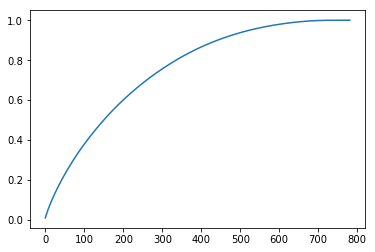

In [254]:
pca = PCA(n_components=782)
pca.fit(Xtrain_tv_ss)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [255]:
# Xtrain_tv_ss_pca = pca.transform(Xtrain_tv_ss)
# Xtest_tv_ss_pca = pca.transform(Xtest_tv_ss)
# Xtrain_tv_ss_pca.shape

# OneVsRestClassifier with LogisticRegression

In [292]:
classif = OneVsRestClassifier(LogisticRegression(C=10.0, penalty='l2'))
classif.fit(Xtrain_tv_ss_pca, Y_train)
classif_predict_train = classif.predict(Xtrain_tv_ss_pca)
classif_predict_test = classif.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, classif_predict_test)
print('train micro f1 score:', f1_score(Y_train, classif_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, classif_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))


train micro f1 score: 0.999481596682
test micro f1 score: 0.692699490662
test classification report:
             precision    recall  f1-score   support

          0       0.78      0.78      0.78         9
          1       0.33      0.50      0.40         2
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.83      0.71      0.77         7
          5       0.00      0.00      0.00         1
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         2
          8       0.76      0.90      0.83        29
          9       0.80      0.87      0.83        23
         10       0.88      1.00      0.93         7
         11       0.00      0.00      0.00         0
         12       0.50      1.00      0.67         1
         13       0.12      0.33      0.18         3
         14       0.00      0.00      0.00         0
         15       0.00      0.00      0.00        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# OneVsRestClassifier with SVC

In [293]:
OvR_SVC = OneVsRestClassifier(SVC(kernel='sigmoid'))
OvR_SVC.fit(Xtrain_tv_ss_pca, Y_train)
OvR_SVC_predict_train = classif.predict(Xtrain_tv_ss_pca)
OvR_SVC_predict_test = classif.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, OvR_SVC_predict_test)
print('train micro f1 score:', f1_score(Y_train, OvR_SVC_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, OvR_SVC_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))


train micro f1 score: 0.999481596682
test micro f1 score: 0.692699490662
test classification report:
             precision    recall  f1-score   support

          0       0.78      0.78      0.78         9
          1       0.33      0.50      0.40         2
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.83      0.71      0.77         7
          5       0.00      0.00      0.00         1
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         2
          8       0.76      0.90      0.83        29
          9       0.80      0.87      0.83        23
         10       0.88      1.00      0.93         7
         11       0.00      0.00      0.00         0
         12       0.50      1.00      0.67         1
         13       0.12      0.33      0.18         3
         14       0.00      0.00      0.00         0
         15       0.00      0.00      0.00        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# OneVsRestClassifier with MLP

In [294]:
OVR_MLP = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(15,15), 
                              solver='adam', 
                              alpha=1e-5,
                              learning_rate='adaptive',
                              activation='logistic',
                              max_iter=4000))
OVR_MLP.fit(Xtrain_tv_ss_pca, Y_train)
OVR_MLP_predict_train = OVR_MLP.predict(Xtrain_tv_ss_pca)
OVR_MLP_predict_test = OVR_MLP.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, OVR_MLP_predict_test)
print('train micro f1 score:', f1_score(Y_train, OVR_MLP_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, OVR_MLP_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))


train micro f1 score: 0.902161547213
test micro f1 score: 0.714003944773
test classification report:
             precision    recall  f1-score   support

          0       0.88      0.78      0.82         9
          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.83      0.71      0.77         7
          5       0.00      0.00      0.00         1
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         2
          8       0.90      0.90      0.90        29
          9       0.83      0.87      0.85        23
         10       0.86      0.86      0.86         7
         11       0.00      0.00      0.00         0
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         3
         14       0.00      0.00      0.00         0
         15       0.00      0.00      0.00        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Recreating previous steps using Pipeline

In [326]:
# Tokenizer
def tokenization(s=None):
    """tokenize each word and for each tocken:
    1. excludes digits and punctuations, 
    2. excludes token that has '-year', 
    3. excludes stop words,
    4. makes the token stemmed,
    and return a string with all tokens separated by a space"""
    nlp = spacy.load('en')
    stop_words = list(ENGLISH_STOP_WORDS)
    custom_stop = ['year', 'month', 'old']
    stop = stop_words + custom_stop
    stemmer = PorterStemmer()
    
    def words2tokens(sentence, nlp, stop, stemmer):
        l = []    
        tokens = nlp(sentence)
        for token in tokens:
            t = token.text.lower()
            if (t in punctuation) or t.isdigit():
                continue
            if ('-year' in t) or ('-month' in t) or ('-day' in t):
                continue
            if ('/' in t) or ('=' in t) or (t in stop):
                continue
            l.append(stemmer.stem(t))
        return ' '.join(l)
    
    Series = s.apply(lambda x: words2tokens(x, nlp, stop, stemmer))    
    return Series
tokenizer = FunctionTransformer(tokenization, validate=False)

# Convert a text series to tfidf matrix 
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=3000)

# Convert a tfidf matrix to a dataframe
def convert2df(tfidf_matrix=None):
    return pd.DataFrame(tfidf_matrix.todense())
matrix_converter = FunctionTransformer(convert2df, validate=False)

# Standardize the dataframe
ss = StandardScaler()

# PCA the dataframe
pca = PCA(n_components=782)

# OneVsRestClassifier with MLP
OVR_MLP = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(15,15), 
                              solver='adam', 
                              alpha=1e-5,
                              learning_rate='adaptive',
                              activation='logistic',
                              max_iter=4000))

pipe = make_pipeline(tokenizer, tfidf, matrix_converter, StandardScaler(), pca, OVR_MLP)

In [29]:
sen = 'Eleven year old with ALL, bone marrow transplant on Jan. 2, now with three day history of cough. 1. No focal pneumonia. Likely chronic changes at the left lung base. 2. Mild anterior wedging of the thoracic vertebral bodies.'
#word_tokenize(sen)
w = word_tokenize()
w(sen)

TypeError: word_tokenize() missing 1 required positional argument: 'text'

In [58]:
# Write tokenizer as a class
class Tokenization(object):
    """tokenize each word and for each tocken:
    1. excludes digits and punctuations, 
    2. excludes token that has '-year', 
    3. excludes stop words,
    4. makes the token stemmed,
    and return a string with all tokens separated by a space"""
    from string import digits, punctuation
    import spacy
    from nltk.tokenize import word_tokenize
    #import en_core_web_sm
    import dill
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    from nltk.stem import PorterStemmer

    def __init__(self, #nlp=word_tokenize()#spacy.load('en_core_web_sm'), 
                 stop=list(ENGLISH_STOP_WORDS)+['year', 'month', 'old'], 
                 stemmer=PorterStemmer()):
        #self.nlp = nlp
        self.stop = stop
        self.stemmer = stemmer

    def fit(self, x, y=None):
        return self
        
    def transform(self, x):
        def words2tokens(sentence, stop=self.stop, stemmer=self.stemmer):
            l = []    
            tokens = word_tokenize(sentence)
            for token in tokens:                
                t = token.lower()
                if (t in punctuation) or t.isdigit():
                    continue
                if ('-year' in t) or ('-month' in t) or ('-day' in t):
                    continue
                if ('/' in t) or ('=' in t) or (t in stop):
                    continue
                l.append(stemmer.stem(t))
            return ' '.join(l)

        series = x.apply(lambda s: words2tokens(s, stop=self.stop, stemmer=self.stemmer))    
        return series

In [33]:
tokenizer = Tokenization()
X_train_token = tokenizer.transform(X_train)
X_train_token.head()

97716758    month-old femal statu post cardiac arrest pers...
99646646    femal grade bilater vesicoureter reflux determ...
97683176    male cough day durat fever rule pneumonia scat...
97682157    male cough evalu pneumonia possibl right lower...
97643664                  reactiv ppd normal chest radiograph
Name: CLINICAL_HISTORY_IMPRESSION, dtype: object

In [59]:
# Write matrix converter as a class
class MatrixConverter(object):
    """Converter a tfidf matrix to a df"""
    def __init__(self):
        pass
    def fit(self, x, y=None):
        return self    
    def transform(self, x):
        return pd.DataFrame(x.todense())

In [35]:
X_train.head()

97716758    Nine - month-old female, status post cardiac a...
99646646    2-year - old female with grade 1/2 bilateral v...
97683176    4-year 5-month - old male with cough of 10 day...
97682157    8-month-13-day - old male with cough. Evaluate...
97643664               Reactive PPD. Normal chest radiograph.
Name: CLINICAL_HISTORY_IMPRESSION, dtype: object

In [60]:
# Tokenizer
tokenizer = Tokenization()

# Convert a text series to tfidf matrix 
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=3000)

# Convert a tfidf matrix to a dataframe
m2df = MatrixConverter()

# Standardize the dataframe
ss = StandardScaler()

# PCA the dataframe
pca = PCA(n_components=782)

# OneVsRestClassifier with MLP
ovr_mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(15,15), 
                              solver='adam', 
                              alpha=1e-5,
                              learning_rate='adaptive',
                              activation='logistic',
                              max_iter=4000))

pipe = make_pipeline(tokenizer, tfidf, m2df, ss, pca, ovr_mlp)

In [61]:
pipe.fit(X_train, Y_train)
OVR_MLP_predict_train = pipe.predict(X_train)
OVR_MLP_predict_test = pipe.predict(X_test)

classification = classification_report(Y_test, OVR_MLP_predict_test)
print('train micro f1 score:', f1_score(Y_train, OVR_MLP_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, OVR_MLP_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 23 is present in all training examples.
  str(classes[c]))
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


train micro f1 score: 0.9289678135405105
test micro f1 score: 0.7321772639691715
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.48      0.82      0.61        17
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         1
          5       0.86      0.86      0.86         7
          6       0.00      0.00      0.00         3
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         2
         10       0.00      0.00      0.00         3
         11       0.00      0.00      0.00         0
         12       0.78      0.78      0.78         9
         13       0.00      0.00      0.00         0
         14       1.00      1.00      1.00         1
         15       0.86      0.86      0.86

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Pickle the pipe and write Test set to csv

In [64]:
import pickle
#conda install requests may be needed
import requests, json
pickle.dump(pipe, open("model_pipe.pkl", "wb"))
X_test.to_csv('X_test', index=False)
Y_test.to_csv('Y_test', index=False)

In [65]:
# Try out pickle 
model = pickle.load(open("model_pipe.pkl", "rb"))
predict_test = model.predict(X_test)
classification = classification_report(Y_test, predict_test)

print('test micro f1 score:', f1_score(Y_test, predict_test, average='micro'))
print('test classification report:')
print(classification)

test micro f1 score: 0.7321772639691715
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.48      0.82      0.61        17
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         1
          5       0.86      0.86      0.86         7
          6       0.00      0.00      0.00         3
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         2
         10       0.00      0.00      0.00         3
         11       0.00      0.00      0.00         0
         12       0.78      0.78      0.78         9
         13       0.00      0.00      0.00         0
         14       1.00      1.00      1.00         1
         15       0.86      0.86      0.86         7
         16       0.00      0.

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [68]:
icd_codes = [code.replace('ICD9_','') for code in Y_test.columns]
pickle.dump(icd_codes, open("icd_codes.pkl", "wb"))

# MLPClassifier with GridSearchCV

In [36]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier()
MLP_params = {'hidden_layer_sizes':[(5, 5), (10, 5), (5, 10), (10, 10), (15, 15)],
              'solver': ['adam', 'sgd', 'lbfgs'],
              'alpha': [1e-5, 1e-4],
              'learning_rate': ['constant', 'adaptive'],
              'activation': ['logistic', 'relu'],
              'max_iter':[2000]
              }

MLP_gs = GridSearchCV(MLP, MLP_params, cv=5, verbose=2, scoring='f1_micro')
MLP_gs.fit(Xtrain_tv_ss_pca, Y_train)
print('best paramerters:', MLP_gs.best_params_)
print('best score:', MLP_gs.best_score_)

train_MLP_gs_predict = MLP_gs.predict(Xtrain_tv_ss_pca)
test_MLP_gs_predict = MLP_gs.predict(Xtest_tv_ss_pca)
#print('micro f1 score:', f1_score(Y_test, MLP_gs_predict, average='micro'))
classification = classification_report(Y_test, test_MLP_gs_predict)
print('train micro f1 score:', f1_score(Y_train, train_MLP_gs_predict, average='micro'))
print('test micro f1 score:', f1_score(Y_test, test_MLP_gs_predict, average='micro'))
print('test classification report:')
print(classification)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  16.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   6.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solv

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solv

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  17.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  15.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  11.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  11.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  11.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  14.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  17.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  11.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  13.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  13.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  15.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   3.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   9.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  18.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  22.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  17.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=  10.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=  12.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=  10.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  13.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  12.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  12.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  10.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  10.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  11.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  10.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   3.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   6.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  10.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  10.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  10.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   6.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=const

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adapt

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  13.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  13.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  43.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  16.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=const

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  21.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  22.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  18.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=  16.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  13.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  13.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adapt

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=   4.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=   4.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=rel

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   4.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   3.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   3.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, 

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=r

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   1.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   1.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   2.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   5.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   6.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   6.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=re

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   8.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   2.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activati

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  11.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  18.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbf

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   3.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   2.9s


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 78.3min finished


best paramerters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (15, 15), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'lbfgs'}
best score: 0.595692439848
train micro f1 score: 0.99948105864
test micro f1 score: 0.630480167015
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00         1
          2       0.84      0.80      0.82        54
          3       0.00      0.00      0.00         0
          4       0.50      0.25      0.33         8
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         1
          7       1.00      0.50      0.67         4
          8       0.25      0.14      0.18         7
          9       0.00      0.00      0.00         2
         10       1.00      0.67      0.80         3
         11       0.00      0.00      0.00         0
         12       0.00     

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [44]:
import pickle
#conda install requests may be needed
import requests, json
pickle.dump(OVR_MLP, open("icd9_svm.pkl", "wb"))

In [45]:
svm_clf = pickle.load(open("icd9_svm.pkl", "rb"))

In [46]:
#print("Accuracy = %0.2f" % accuracy_score (y_test, my_svm.predict(X_test)))
svm_clf_predict_test = svm_clf.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, svm_clf_predict_test)

print('test micro f1 score:', f1_score(Y_test, svm_clf_predict_test, average='micro'))
print('test classification report:')
print(classification)

test micro f1 score: 0.720156555773
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00         1
          2       0.82      0.87      0.85        54
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         8
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         1
          7       0.00      0.00      0.00         4
          8       0.00      0.00      0.00         7
          9       0.00      0.00      0.00         2
         10       0.00      0.00      0.00         3
         11       0.00      0.00      0.00         0
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         0
         14       0.00      0.00      0.00         0
         15       0.90      0.83      0.86        23
         16       0.54      0.82  

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [55]:
pd.DataFrame(Xtest_tv_ss_pca).to_csv('Xtest_tv_ss_pca', index=False)

In [56]:
pd.DataFrame(Y_test).to_csv('Y_test', index=False)

In [57]:
Y_test.shape

(196, 45)

# OneVsRestClassifier - GBC 

In [303]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = OneVsRestClassifier(GradientBoostingClassifier(max_depth=4, n_estimators=500))
clf.fit(Xtrain_tv_ss_pca, Y_train)
clf_predict_train = clf.predict(Xtrain_tv_ss_pca)
clf_predict_test = clf.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, clf_predict_test)
print('train micro f1 score:', f1_score(Y_train, clf_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, clf_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 35 is present in all training examples.
  str(classes[c]))


train micro f1 score: 1.0
test micro f1 score: 0.400966183575
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.41      0.59        29
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         7
          4       0.00      0.00      0.00         7
          5       0.10      1.00      0.18         3
          6       0.50      0.25      0.33         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         3
         12       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         0
         14       0.00      0.00      0.00         1
         15       1.00      0.50      0.67         2
        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# OneVsRestClassifier - Neural Network

In [299]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(15,15), 
                                        solver='adam', 
                                        alpha=1e-5,
                                        learning_rate='adaptive',
                                        activation='logistic',
                                        max_iter=3000))
clf.fit(Xtrain_tv_ss_pca, Y_train)
clf_predict_train = clf.predict(Xtrain_tv_ss_pca)
clf_predict_test = clf.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, clf_predict_test)
print('train micro f1 score:', f1_score(Y_train, clf_predict_train, average='micro'))
print('test micro f1 score:', f1_score(Y_test, clf_predict_test, average='micro'))
print('test classification report:')
print(classification)

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 35 is present in all training examples.
  str(classes[c]))


train micro f1 score: 0.902272727273
test micro f1 score: 0.706333973129
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.87      0.90      0.88        29
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         7
          4       0.83      0.71      0.77         7
          5       0.00      0.00      0.00         3
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         3
         12       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         0
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Neural Network and GridSearchCV

In [261]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

MLP = MLPClassifier()
MLP_params = {'hidden_layer_sizes':[(5, 5), (10, 5), (5, 10), (10, 10), (15, 15)],
              'solver': ['adam', 'sgd', 'lbfgs'],
              'alpha': [1e-5, 1e-4],
              'learning_rate': ['constant', 'adaptive'],
              'activation': ['logistic', 'relu'],
              'max_iter':[2000]
              }

MLP_gs = GridSearchCV(MLP, MLP_params, cv=5, verbose=2, scoring='f1_micro')
MLP_gs.fit(Xtrain_tv_ss_pca, Y_train)
print('best paramerters:', MLP_gs.best_params_)
print('best score:', MLP_gs.best_score_)

train_MLP_gs_predict = MLP_gs.predict(Xtrain_tv_ss_pca)
test_MLP_gs_predict = MLP_gs.predict(Xtest_tv_ss_pca)
#print('micro f1 score:', f1_score(Y_test, MLP_gs_predict, average='micro'))
classification = classification_report(Y_test, test_MLP_gs_predict)
print('train micro f1 score:', f1_score(Y_train, train_MLP_gs_predict, average='micro'))
print('test micro f1 score:', f1_score(Y_test, test_MLP_gs_predict, average='micro'))
print('test classification report:')
print(classification)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  11.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  14.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  16.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  16.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   9.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solv

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solv

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  13.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   9.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   4.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  11.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  15.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  15.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=   3.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  15.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  18.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  13.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  12.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.1s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   9.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=  14.6s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.4s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  11.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  12.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   9.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=  11.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=20

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  17.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  18.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  15.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  13.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=  17.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  14.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  16.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  13.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  10.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  12.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   4.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=constant, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=   5.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  13.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  18.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  16.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  18.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=adam, total=  14.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   5.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  11.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   9.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   8.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=const

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  18.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  15.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  14.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=adam, total=  12.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  11.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  12.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  13.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adapt

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  19.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  17.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  14.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  15.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=adam, total=  18.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, 

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   7.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   4.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  27.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  14.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=  10.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=const

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  21.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  18.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  16.9s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=adam, total=  17.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.7s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.8s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.3s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  12.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  11.6s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=  15.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adapt

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   8.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   5.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=   7.2s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam, total=   4.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 5), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=rel

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   5.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   7.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=adam, total=   4.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(5, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, 

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   8.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   9.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=sgd, total=   6.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(10, 10), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=r

[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   2.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   4.6s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   2.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   6.4s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(15, 15), learning_rate=constant, max_iter=2000, solver=lbfgs 
[CV]

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=constant, max_iter=2000, solver=lbfgs, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   3.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=re

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   6.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=adam, total=   4.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 5), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   4.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   5.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=sgd, total=   6.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(5, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activati

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   9.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   4.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   4.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 10), learning_rate=adaptive, max_iter=2000, solver=lbf

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   7.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(15, 15), learning_rate=adaptive, max_iter=2000, solver=lbfgs, total=   1.0s


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 86.1min finished


best paramerters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (15, 15), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'lbfgs'}
best score: 0.584763447775
train micro f1 score: 1.0
test micro f1 score: 0.61932938856
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.91      0.69      0.78        29
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         7
          4       1.00      0.14      0.25         7
          5       0.67      0.67      0.67         3
          6       0.50      0.50      0.50         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.40      0.67      0.50         3
         12       0.00      0.00      

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# ExtraTree and GridSearchCV

In [269]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

ETC = ExtraTreesClassifier()
ETC_params = {'n_estimators':[100, 300, 500],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [3, 5, 7]}
#              'activation': ['logistic', 'relu'],
#              'max_iter':[2000]
#              }

ETC_gs = GridSearchCV(ETC, ETC_params, cv=5, verbose=2, scoring='f1_micro')
ETC_gs.fit(Xtrain_tv_ss_pca, Y_train)
print('best paramerters:', ETC_gs.best_params_)
print('best score:', ETC_gs.best_score_)

train_ETC_gs_predict = ETC_gs.predict(Xtrain_tv_ss_pca)
test_ETC_gs_predict = ETC_gs.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, test_ETC_gs_predict)
print('train micro f1 score:', f1_score(Y_train, train_ETC_gs_predict, average='micro'))
print('test micro f1 score:', f1_score(Y_test, test_ETC_gs_predict, average='micro'))
print('test classification report:')
print(classification)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.5s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.9s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.6s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.5s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   4.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   1.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   3.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   3.2s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   4.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   4.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   5.6s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.4s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.5s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.5s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   1.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.1s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   4.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   1.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.6s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.2s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.0s
[CV] max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=3, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   4.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   4.1s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   4.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.0s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   3.4s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.6s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.5s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   5.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.9s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.9s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.1s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.6s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.5s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.6s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.3s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.4s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   5.0s
[CV] max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=5, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   4.7s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   4.0s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   3.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   4.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, n_estimators=500, total=   4.7s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.7s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300, total=   2.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.1s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   4.0s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=3, n_estimators=500, total=   4.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.3s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.8s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500, total=   3.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=2, n_estimators=500, total=   3.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.4s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   4.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=3, n_estimators=500, total=   3.6s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.8s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.5s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=300, total=   2.2s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   3.9s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   4.1s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500 


/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   4.5s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   5.4s
[CV] max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500 
[CV]  max_depth=7, min_samples_leaf=7, min_samples_split=5, n_estimators=500, total=   4.1s


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 20.5min finished


best paramerters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}
best score: 0.012260294494
train micro f1 score: 0.0661985957874
test micro f1 score: 0.015625
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00        29
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         7
          4       0.00      0.00      0.00         7
          5       0.00      0.00      0.00         3
          6       0.00      0.00      0.00         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         3
         12       0.00      0.00      0.00         2
         13       0.00      0.0

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [271]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

knn = KNeighborsClassifier()
knn_params = {'n_neighbors':[3, 4, 5],
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 3]}#,
#              'min_samples_leaf': [3, 5, 7]}
#              'activation': ['logistic', 'relu'],
#              'max_iter':[2000]
#              }

knn_gs = GridSearchCV(knn, knn_params, cv=5, verbose=2, scoring='f1_micro')
knn_gs.fit(Xtrain_tv_ss_pca, Y_train)
print('best paramerters:', knn_gs.best_params_)
print('best score:', knn_gs.best_score_)

train_knn_gs_predict = knn_gs.predict(Xtrain_tv_ss_pca)
test_knn_gs_predict = knn_gs.predict(Xtest_tv_ss_pca)
classification = classification_report(Y_test, test_knn_gs_predict)
print('train micro f1 score:', f1_score(Y_train, train_knn_gs_predict, average='micro'))
print('test micro f1 score:', f1_score(Y_test, test_knn_gs_predict, average='micro'))
print('test classification report:')
print(classification)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=3, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.1s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.2s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.1s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.1s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] .

[CV] ............. n_neighbors=4, p=3, weights=distance, total=   2.3s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.2s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.1s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.1s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] ............. n_neighbors=5, p=1, weights=distance, total=   0.1s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  6.2min finished


train micro f1 score: 1.0
test micro f1 score: 0.407894736842
test classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.88      0.24      0.38        29
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         7
          4       1.00      0.14      0.25         7
          5       0.00      0.00      0.00         3
          6       1.00      0.50      0.67         4
          7       0.00      0.00      0.00         1
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         3
         12       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         0
         14       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         2
        

/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cysung/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
import pickle
#conda install requests will be needed
import requests, json
pickle.dump(model, open("icd9_svm.pkl", "wb"))

In [ ]:
# load back pickled file 
my_svm = pickle.load(open("icd9_svm.pkl", "rb"))

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy = %0.2f" % accuracy_score (y_test, my_svm.predict(X_test)))
#print(classification_report(y_test, my_svm.predict(X_test)))

In [278]:
import spacy

nlp = spacy.load('en')
doc = nlp("Let's go to N.Y.!")
doc

Let's go to N.Y.!

In [279]:
for token in doc:
    print(token.text)

Let
's
go
to
N.Y.
!


In [281]:
[token.text.lower() for token in doc]

['let', "'s", 'go', 'to', 'n.y.', '!']

In [ ]:
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in list1]

# Voting Classifier 

In [239]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
list_of_classifiers = [
#    ('logreg', LogisticRegression()),
#   ('sgd_cls', SGDClassifier()),
#   ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())
]
vclf = VotingClassifier(list_of_classifiers, voting='soft')
params = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__penalty': ['l1', 'l2'],
#   'sgd_cls__loss':['log'], #, 'squared_loss'],
#   'sgd_cls__penalty':['elasticnet'],
#   'sgd_cls__alpha':np.logspace(-1,1,5),
#   'sgd_cls__l1_ratio':[i/10.0 for i in range(6)],
#   'dt__max_depth': [3, 5, 7, 9],
    'rf__max_depth': [5, 7],
    'rf__n_estimators': [100, 500],
    'gb__max_depth': [5, 7],
    'gb__n_estimators': [100, 500],
}

gs = GridSearchCV(vclf, params, verbose=2)    
gs.fit(Xtrain, ytrain)

In [205]:
X, Y = make_multilabel_classification(n_classes=5, n_labels=4,
                                      allow_unlabeled=False,
                                      random_state=1)

In [206]:
X.shape

(100, 20)

In [207]:
Y.shape

(100, 5)

In [208]:
pd.DataFrame(Y).head()

,0,1,2,3,4
0,0,0,0,0,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,0,1,1
4,1,1,0,0,0


In [209]:
df_Y = pd.DataFrame(Y)
df_Y.head()

,0,1,2,3,4
0,0,0,0,0,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,0,1,1
4,1,1,0,0,0


In [210]:
df_Y.columns

RangeIndex(start=0, stop=5, step=1)

In [211]:
df_Y['sum'] = df_Y[0] + df_Y[1] + df_Y[2]+ df_Y[3] + df_Y[4]
df_Y.tail()

,0,1,2,3,4,sum
95,1,1,0,1,1,4
96,1,1,0,1,1,4
97,1,1,0,1,1,4
98,1,1,0,1,1,4
99,0,0,0,1,0,1


In [212]:
df_Y.describe()

,0,1,2,3,4,sum
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.800000,0.870000,0.120000,0.740000,0.590000,3.120000
std,0.402015,0.337998,0.326599,0.440844,0.494311,1.241374
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [172]:
pd.DataFrame(Y)[2].unique()

array([0, 1])

In [256]:
'A' != 'B'

True

In [238]:
from nltk.tokenize import word_tokenize
# gen_docs = [[w.lower() for w in word_tokenize(text)] 
#             for text in list1]
# print(gen_docs)

In [242]:
first = df['CHI_stemmed_stopped'][0]
first

'bone marrow transplant jan day histori cough No focal pneumonia like chronic chang left lung base mild anterior wedg thorac vertebr bodi'

In [250]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/cysung/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [251]:
from nltk.tokenize import word_tokenize

In [254]:
len(first.split())

22

In [255]:
len(word_tokenize(first))

22

LDA reference: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

Vectorize using tf-idf

In [ ]:
df

In [182]:
test

'Eleven year old with ALL bone marrow transplant on Jan  now with three day history of cough  No focal pneumonia Likely chronic changes at the left lung base  Mild anterior wedging of the thoracic vertebral bodies'

In [192]:
stemmer.stem('thoracic')

'thorac'

In [ ]:
#s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)
#res = s.translate(remove_digits)
#res
df['no_number'] = df['re_number'].str.translate(remove_digits)
df.head()

In [97]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

In [419]:
# convert sentence column to sentence list 
sen = df['sentences'].tolist()
s =[]
for w in sen:
    words = word_tokenize(w)
    s.append(words)
s

[['1',
  'year',
  'old',
  'with',
  'history',
  'of',
  'bilateral',
  'vesicoureteral',
  'reflux',
  ',',
  'left',
  'sided',
  'hydronephrosis',
  'on',
  'prenatal',
  'ultrasound',
  '.'],
 ['1-1/2-year',
  '-',
  'old',
  'male',
  'follow',
  'up',
  'left',
  'hydronephrosis',
  'after',
  'ureteral',
  'reimplants',
  '.'],
 ['1-month',
  '-',
  'old',
  'male',
  'with',
  'history',
  'of',
  'hydronephrosis',
  '.',
  'Followup',
  'study',
  '.'],
 ['1-year',
  ',',
  '1-month',
  '-',
  'old',
  'female',
  'with',
  'cloacal',
  'anomaly',
  'and',
  'solitary',
  'left',
  'kidney',
  'status',
  'post',
  'ureterostomy',
  'for',
  'high',
  '-',
  'grade',
  'reflux',
  '.'],
 ['10-year',
  '-',
  'old',
  'girl',
  'with',
  'history',
  'of',
  'Deflux',
  'procedures',
  '.',
  'The',
  'patient',
  'then',
  'presented',
  'with',
  'gross',
  'hematuria',
  'to',
  'the',
  'emergency',
  'department',
  '.'],
 ['10-year',
  '-',
  'old',
  'with',
  'history

In [420]:
df['list'] = s
df.head()

,ICD_9,Type,sentences,list
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v..."
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h..."
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd..."
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo..."
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def..."


In [421]:
# iterate through each word in the list and perform stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
df['stemmed'] = df["list"].apply(lambda x: [stemmer.stem(y) for y in x])
#df['stemmed'] = df["sentences"].apply(lambda x: [stemmer.stem(x)])

df.head()

,ICD_9,Type,sentences,list,stemmed
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves..."
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h..."
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd..."
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa..."
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def..."


In [422]:
# remove punctuation
import string
print(string.punctuation)

df['s_r'] = df['stemmed'].apply(lambda x: [item for item in x if item not in string.punctuation])
df.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,ICD_9,Type,sentences,list,stemmed,s_r
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...","[1, year, old, with, histori, of, bilater, ves..."
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, old, male, follow, up, left, hydr..."
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...","[1-month, old, male, with, histori, of, hydron..."
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...","[1-year, 1-month, old, femal, with, cloacal, a..."
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...","[10-year, old, girl, with, histori, of, deflux..."


In [423]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['s_r'] = df['s_r'].apply(lambda x: [item for item in x if item not in stop])

df.head()

,ICD_9,Type,sentences,list,stemmed,s_r
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...","[1, year, old, histori, bilater, vesicoureter,..."
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, old, male, follow, left, hydronep..."
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...","[1-month, old, male, histori, hydronephrosi, f..."
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...","[1-year, 1-month, old, femal, cloacal, anomali..."
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...","[10-year, old, girl, histori, deflux, procedur..."


In [424]:
# remove list from s_r
df['s_r'] = df['s_r'].apply(lambda x: ','.join(x))


In [425]:
# remove , from s_r
df.s_r.replace(',', ' ',regex=True,inplace=True)
df.head()

,ICD_9,Type,sentences,list,stemmed,s_r
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...",1 year old histori bilater vesicoureter reflux...
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...",1-1/2-year old male follow left hydronephrosi ...
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...",1-month old male histori hydronephrosi followu...
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...",1-year 1-month old femal cloacal anomali solit...
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...",10-year old girl histori deflux procedur patie...


In [426]:
df[:1]['sentences'] # oringinal sentence

443    1 year old with history of bilateral vesicoure...
Name: sentences, dtype: object

In [427]:
df[:1]['list'] # put sentence into list for the purpose of stemming 

443    [1, year, old, with, history, of, bilateral, v...
Name: list, dtype: object

In [428]:
df[:1]['stemmed'] # after stemming

443    [1, year, old, with, histori, of, bilater, ves...
Name: stemmed, dtype: object

In [429]:
df[:1]['s_r'] # after remove punctuation and stopword 

443    1 year old histori bilater vesicoureter reflux...
Name: s_r, dtype: object

In [430]:
df.head()

,ICD_9,Type,sentences,list,stemmed,s_r
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...",1 year old histori bilater vesicoureter reflux...
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...",1-1/2-year old male follow left hydronephrosi ...
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...",1-month old male histori hydronephrosi followu...
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...",1-year 1-month old femal cloacal anomali solit...
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...",10-year old girl histori deflux procedur patie...


In [431]:
# remove number from sentence
import re
#df['re_number'] = df['no_number'].replace('\d+', '')
#s = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", s)
df['re_number'] = df['s_r'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))
df.head()

,ICD_9,Type,sentences,list,stemmed,s_r,re_number
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...",1 year old histori bilater vesicoureter reflux...,year old histori bilater vesicoureter reflux ...
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...",1-1/2-year old male follow left hydronephrosi ...,1-1/2-year old male follow left hydronephrosi ...
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...",1-month old male histori hydronephrosi followu...,1-month old male histori hydronephrosi followu...
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...",1-year 1-month old femal cloacal anomali solit...,1-year 1-month old femal cloacal anomali solit...
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...",10-year old girl histori deflux procedur patie...,10-year old girl histori deflux procedur patie...


In [450]:
# remove number from words 

from string import digits

#s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)
#res = s.translate(remove_digits)
#res
df['no_number'] = df['re_number'].str.translate(remove_digits)
df.head()

,ICD_9,Type,sentences,list,stemmed,s_r,re_number,no_number
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...",1 year old histori bilater vesicoureter reflux...,year old histori bilater vesicoureter reflux ...,year old histori bilater vesicoureter reflux ...
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...",1-1/2-year old male follow left hydronephrosi ...,1-1/2-year old male follow left hydronephrosi ...,-/-year old male follow left hydronephrosi ure...
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...",1-month old male histori hydronephrosi followu...,1-month old male histori hydronephrosi followu...,-month old male histori hydronephrosi followup...
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...",1-year 1-month old femal cloacal anomali solit...,1-year 1-month old femal cloacal anomali solit...,-year -month old femal cloacal anomali solitar...
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...",10-year old girl histori deflux procedur patie...,10-year old girl histori deflux procedur patie...,-year old girl histori deflux procedur patient...


In [454]:
# remove punctuation from words

table = str.maketrans({key: None for key in string.punctuation})
df['no_number'] = df['no_number'].str.translate(table)     

#s.translate(None, string.punctuation)
df.head()

,ICD_9,Type,sentences,list,stemmed,s_r,re_number,no_number
443,591,CLINICAL_HISTORY,1 year old with history of bilateral vesicoure...,"[1, year, old, with, history, of, bilateral, v...","[1, year, old, with, histori, of, bilater, ves...",1 year old histori bilater vesicoureter reflux...,year old histori bilater vesicoureter reflux ...,year old histori bilater vesicoureter reflux ...
444,591,CLINICAL_HISTORY,1-1/2-year - old male follow up left hydroneph...,"[1-1/2-year, -, old, male, follow, up, left, h...","[1-1/2-year, -, old, male, follow, up, left, h...",1-1/2-year old male follow left hydronephrosi ...,1-1/2-year old male follow left hydronephrosi ...,year old male follow left hydronephrosi ureter...
445,591,CLINICAL_HISTORY,1-month - old male with history of hydronephro...,"[1-month, -, old, male, with, history, of, hyd...","[1-month, -, old, male, with, histori, of, hyd...",1-month old male histori hydronephrosi followu...,1-month old male histori hydronephrosi followu...,month old male histori hydronephrosi followup ...
446,591,CLINICAL_HISTORY,"1-year, 1-month - old female with cloacal anom...","[1-year, ,, 1-month, -, old, female, with, clo...","[1-year, ,, 1-month, -, old, femal, with, cloa...",1-year 1-month old femal cloacal anomali solit...,1-year 1-month old femal cloacal anomali solit...,year month old femal cloacal anomali solitari ...
447,591,CLINICAL_HISTORY,10-year - old girl with history of Deflux proc...,"[10-year, -, old, girl, with, history, of, Def...","[10-year, -, old, girl, with, histori, of, def...",10-year old girl histori deflux procedur patie...,10-year old girl histori deflux procedur patie...,year old girl histori deflux procedur patient ...


In [447]:
df.shape

(1770, 8)

In [458]:
# check most frequent words
df.no_number.str.split(expand=True).stack().value_counts()

cough             546
old               484
left              424
right             404
pneumonia         378
fever             370
kidney            364
year              349
normal            335
hydronephrosi     254
month             227
reflux            219
histori           216
interv            199
mild              190
growth            188
focal             185
diseas            185
femal             182
male              174
patient           152
bilater           150
airway            148
viral             140
day               135
reactiv           124
vesicoureter      123
chest             122
renal             121
grade             119
                 ... 
regress             1
simpl               1
held                1
presum              1
nephrolithiasi      1
fulgur              1
web                 1
emerg               1
tortuos             1
runni               1
seneg               1
impress             1
append              1
twelv               1
follicl   

# TF-IDF

In [558]:
import nltk
from nltk.corpus import stopwords

# Use line below for just unigrams
# remove stopword and numbers
#v = TfidfVectorizer(stop_words='english',token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

# Use line below for unigrams, bigrams, and trigrams
v = TfidfVectorizer(stop_words='english',token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',ngram_range=(1,3))  



X = v.fit_transform(df['re_number']).toarray()

convoDF = pd.DataFrame() # Initialize new DF

for i, col in enumerate(v.get_feature_names()):
    convoDF[col] = X[:, i]

In [559]:
convoDF

,2nd,2nd right,2nd right grade,3rd,3rd consid,3rd consid normal,5th,5th percentil,5th percentil age,95th,...,year old wheez,year period,year period right,year question,year question parenchym,yesterday,zone,zone clinic,zone clinic correl,zone consolid
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [436]:
list(convoDF.columns.values)


['2nd',
 '3rd',
 '5th',
 '95th',
 'abdomen',
 'abdomin',
 'abnorm',
 'abov',
 'abscess',
 'absenc',
 'absent',
 'accord',
 'account',
 'acquir',
 'activ',
 'acut',
 'addit',
 'adenoid',
 'adenopathi',
 'adjac',
 'administr',
 'adopt',
 'aerat',
 'afternoon',
 'age',
 'ago',
 'air',
 'airspac',
 'airway',
 'albuterol',
 'aldrich',
 'allergi',
 'altern',
 'ambul',
 'amen',
 'ami',
 'anecho',
 'angl',
 'angul',
 'ani',
 'annual',
 'anomali',
 'antenat',
 'anterior',
 'antibiot',
 'antibodi',
 'antrum',
 'aorta',
 'appar',
 'appear',
 'append',
 'appetit',
 'appreci',
 'appropri',
 'approxim',
 'area',
 'arteri',
 'aryepiglott',
 'aspect',
 'aspir',
 'assess',
 'associ',
 'ast',
 'asthma',
 'asthmat',
 'asymmetr',
 'asymmetri',
 'asymptomat',
 'atelectasi',
 'atroph',
 'atrophi',
 'attempt',
 'attend',
 'attenu',
 'atyp',
 'augment',
 'avail',
 'bacteri',
 'bactrim',
 'band',
 'barki',
 'base',
 'baselin',
 'basi',
 'basilar',
 'befor',
 'bertin',
 'best',
 'better',
 'bibasilar',
 'bifid'

In [524]:
scaler = StandardScaler()
scaler.fit(convoDF)
x_s = scaler.transform(convoDF)
x_s

#Y.head()

array([[-0.02377585, -0.02377585, -0.02377585, ...,  1.12979473,
        -0.03277231, -0.03919339],
       [-0.02377585, -0.02377585, -0.02377585, ...,  1.15198525,
        -0.03277231, -0.03919339],
       [-0.02377585, -0.02377585, -0.02377585, ..., -0.47462412,
        -0.03277231, -0.03919339],
       ..., 
       [-0.02377585, -0.02377585, -0.02377585, ..., -0.47462412,
        -0.03277231, -0.03919339],
       [-0.02377585, -0.02377585, -0.02377585, ..., -0.47462412,
        -0.03277231, -0.03919339],
       [-0.02377585, -0.02377585, -0.02377585, ..., -0.47462412,
        -0.03277231, -0.03919339]])

In [ ]:
# save scaler so it can be used on new data to transform it the same way it did on the training set
#import pickle
#scalerfile = 'scaler.sav'
#pickle.dump(scaler, open(scalerfile, 'wb'))

# PCA on tf-idf features 
* https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/

In [546]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline



In [547]:
#convert it to numpy arrays
X=convoDF.values

In [548]:
#Scaling the values
X = scale(X)

In [549]:
pca = PCA(n_components=900)

pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=900, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

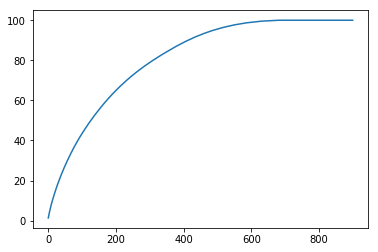

In [550]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var1


plt.plot(var1)

In [551]:
#Looking at above plot I'm taking 1000 variables
pca = PCA(n_components=600)
pca.fit(X)
X1=pca.fit_transform(X)

X1

array([[-0.31008297, -1.80163656, -0.29374733, ...,  0.00464038,
        -0.07702459, -0.24300141],
       [-0.28580723, -1.73281714, -0.06775344, ..., -0.88997208,
        -0.61943056, -0.01010706],
       [-0.28112275, -1.64652556, -0.32820667, ...,  0.1964777 ,
         0.04742063,  0.01104072],
       ..., 
       [-0.01452938,  1.67507069,  0.04420218, ..., -0.08169299,
         0.65748479,  0.02621758],
       [ 0.02737872,  2.16646641,  0.11188039, ...,  0.36748769,
        -0.79688061,  0.17779898],
       [ 0.07614916,  2.28394498,  0.02081195, ...,  0.28369434,
        -0.02217401,  0.28064755]])

# LDA
* http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py
* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html



In [581]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis(n_components=600)
X_r2 = lda.fit(x_s, Y).transform(x_s)


/Users/ej/anaconda3/envs/py360/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [582]:
X_r2

array([[-10.6922794 ,  -0.2730571 ,  -0.0570828 ],
       [ -7.73264944,   3.59299995,  -0.14531425],
       [ -5.88097431,   2.66563572,   0.22539766],
       ..., 
       [  5.16858822,  -0.16247607,   2.43193992],
       [  3.19071427,  -1.18836083,  -0.78130267],
       [  4.37296604,   0.05054069,  -0.62058735]])

In [577]:
len(X_r2)

1770

# Random forest for feature improtance

Feature ranking:
1. feature 400 (0.058677)
2. feature 329 (0.054832)
3. feature 710 (0.053384)
4. feature 189 (0.038937)
5. feature 466 (0.036243)
6. feature 952 (0.027776)
7. feature 474 (0.023747)
8. feature 376 (0.022533)
9. feature 451 (0.020134)
10. feature 344 (0.018569)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

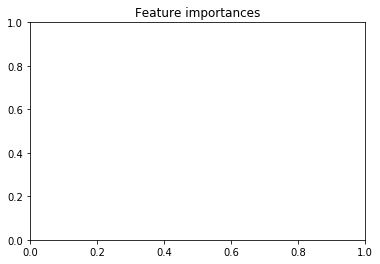

In [544]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_s, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# split data into training and testing

In [552]:
Y = df['ICD_9']

In [586]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2, random_state=42)
X_train
y_train[:5]

2097    780.6
2219    780.6
3210    786.2
2763    786.2
973     593.7
Name: ICD_9, dtype: object

In [587]:
len(X_train)

1416

# Word2Vec
* http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
* https://rare-technologies.com/word2vec-tutorial/

In [463]:
sentence_list = df['no_number'].tolist()
sentence_list

[' year old histori bilater vesicoureter reflux left side hydronephrosi prenat ultrasound',
 'year old male follow left hydronephrosi ureter reimplant',
 'month old male histori hydronephrosi followup studi',
 'year month old femal cloacal anomali solitari left kidney status post ureterostomi high grade reflux',
 'year old girl histori deflux procedur patient present gross hematuria emerg depart',
 'year old histori left ureterocel left mild hydronephrosi',
 'month old histori hydronephrosi vesicoureter reflux status post vesicostomi previous ultrasound demonstr small kidney abnorm echogen',
 'year old femal left pelvic kidney neurogen bladder sever reflux left kidney',
 'day old male clinic prenat histori bilater hydronephrosi report patient s mother prenat imag right hydronephrosi wors left',
 'year old femal refer followup left side hydronephrosi status post pyeloplasti stent remov also evalu renal calculi',
 'day old femal prenat histori right side hydronephrosi',
 'year old femal 

In [464]:
len(sentence_list)

1770

In [465]:
# remove punctuation
import string
list1 = [''.join(c for c in s if c not in string.punctuation) for s in sentence_list]
list1

[' year old histori bilater vesicoureter reflux left side hydronephrosi prenat ultrasound',
 'year old male follow left hydronephrosi ureter reimplant',
 'month old male histori hydronephrosi followup studi',
 'year month old femal cloacal anomali solitari left kidney status post ureterostomi high grade reflux',
 'year old girl histori deflux procedur patient present gross hematuria emerg depart',
 'year old histori left ureterocel left mild hydronephrosi',
 'month old histori hydronephrosi vesicoureter reflux status post vesicostomi previous ultrasound demonstr small kidney abnorm echogen',
 'year old femal left pelvic kidney neurogen bladder sever reflux left kidney',
 'day old male clinic prenat histori bilater hydronephrosi report patient s mother prenat imag right hydronephrosi wors left',
 'year old femal refer followup left side hydronephrosi status post pyeloplasti stent remov also evalu renal calculi',
 'day old femal prenat histori right side hydronephrosi',
 'year old femal 

In [466]:
# We will use NLTK to tokenize.
# A document will now be a list of tokens.

from nltk.tokenize import word_tokenize
gen_docs = [[w.lower() for w in word_tokenize(text)] 
            for text in list1]
print(gen_docs)

[['year', 'old', 'histori', 'bilater', 'vesicoureter', 'reflux', 'left', 'side', 'hydronephrosi', 'prenat', 'ultrasound'], ['year', 'old', 'male', 'follow', 'left', 'hydronephrosi', 'ureter', 'reimplant'], ['month', 'old', 'male', 'histori', 'hydronephrosi', 'followup', 'studi'], ['year', 'month', 'old', 'femal', 'cloacal', 'anomali', 'solitari', 'left', 'kidney', 'status', 'post', 'ureterostomi', 'high', 'grade', 'reflux'], ['year', 'old', 'girl', 'histori', 'deflux', 'procedur', 'patient', 'present', 'gross', 'hematuria', 'emerg', 'depart'], ['year', 'old', 'histori', 'left', 'ureterocel', 'left', 'mild', 'hydronephrosi'], ['month', 'old', 'histori', 'hydronephrosi', 'vesicoureter', 'reflux', 'status', 'post', 'vesicostomi', 'previous', 'ultrasound', 'demonstr', 'small', 'kidney', 'abnorm', 'echogen'], ['year', 'old', 'femal', 'left', 'pelvic', 'kidney', 'neurogen', 'bladder', 'sever', 'reflux', 'left', 'kidney'], ['day', 'old', 'male', 'clinic', 'prenat', 'histori', 'bilater', 'hydr

In [467]:
#model = Word2Vec(gen_docs)
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))
import gensim

model = gensim.models.Word2Vec(gen_docs, size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [468]:
print(model)
print(w2v)

Word2Vec(vocab=393, size=100, alpha=0.025)
{'cough': array([ 0.27099878, -0.04225826, -0.26975861, -0.32846418,  0.06565496,
       -0.02111882, -0.23524754, -0.20300327,  0.11564869,  0.00974406,
        0.12913121,  0.13241479,  0.05256188,  0.12228753, -0.27469036,
        0.00447896, -0.01292065,  0.30745813, -0.07293808, -0.28875273,
        0.17708251,  0.1811109 ,  0.29425502,  0.09552145, -0.20890753,
        0.08399144,  0.23972939,  0.06733823,  0.00216189,  0.10069591,
        0.06995509,  0.01817981, -0.13639686, -0.15118366, -0.08337896,
        0.28443182, -0.11741713,  0.03108745,  0.18330644,  0.01822166,
        0.10470396,  0.19517697,  0.17022021,  0.05651771, -0.22243755,
       -0.11386047, -0.04706922, -0.12909506, -0.16033964,  0.10418769,
        0.47636366, -0.07322252,  0.02304845,  0.15509219,  0.02091833,
       -0.09792942,  0.1268836 , -0.21911435,  0.20559813, -0.20055304,
       -0.62311518, -0.09038392, -0.07391585,  0.04933089, -0.20289271,
       -0.2

In [469]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        #self.dim = len(word2vec.values().next())
        self.dim = 100
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [470]:
a = MeanEmbeddingVectorizer(w2v)
a

In [471]:
# https://stackoverflow.com/questions/47936578/word2vec-vector-representation-for-text-classification-algorithm
des_w2v = a.transform(gen_docs)
des_w2v

array([[ 0.27469945, -0.03272533, -0.26552328, ..., -0.20281722,
        -0.09153495,  0.05399963],
       [ 0.28930271, -0.03475941, -0.27928194, ..., -0.21141432,
        -0.09510655,  0.05871972],
       [ 0.27490753, -0.03367862, -0.26582778, ..., -0.19918157,
        -0.08983755,  0.05556913],
       ..., 
       [ 0.27045304, -0.02970822, -0.26612696, ..., -0.20152344,
        -0.08801405,  0.05173405],
       [ 0.30654064, -0.03083629, -0.29599974, ..., -0.22618498,
        -0.09896541,  0.0519687 ],
       [ 0.30850387, -0.03342171, -0.29963058, ..., -0.23054239,
        -0.09591528,  0.05041365]])

In [472]:
len(des_w2v)

1770

In [473]:
Y = df['ICD_9']

In [474]:
X_train, X_test, y_train, y_test = train_test_split(des_w2v, Y, test_size=0.2, random_state=42)
X_train
y_train[:5]

2097    780.6
2219    780.6
3210    786.2
2763    786.2
973     593.7
Name: ICD_9, dtype: object

# Keras Deep Learning Library
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [569]:
# when using the categorical_crossentropy loss, need to transfer target variable to categorical format 
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y,4)


In [572]:
len(X_train)

1416

In [588]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

model = Sequential()
model.add(Dense(128, input_dim= 600, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



model.fit(X_train, dummy_y, epochs=10, batch_size=10)

Epoch 1/10
1416/1416 [==============================] - 2s 1ms/step - loss: 1.7953 - acc: 0.4548
Epoch 2/10
1416/1416 [==============================] - 1s 389us/step - loss: 0.9802 - acc: 0.6603
Epoch 3/10
1416/1416 [==============================] - 1s 441us/step - loss: 0.7240 - acc: 0.7203
Epoch 4/10
1416/1416 [==============================] - 1s 398us/step - loss: 0.5604 - acc: 0.7620
Epoch 5/10
1416/1416 [==============================] - 1s 378us/step - loss: 0.5129 - acc: 0.7895
Epoch 6/10
1416/1416 [==============================] - 1s 421us/step - loss: 0.4794 - acc: 0.7910
Epoch 7/10
1416/1416 [==============================] - 1s 380us/step - loss: 0.4629 - acc: 0.7903
Epoch 8/10
1416/1416 [==============================] - 1s 436us/step - loss: 0.4386 - acc: 0.8008
Epoch 9/10
1416/1416 [==============================] - 1s 422us/step - loss: 0.4099 - acc: 0.7931
Epoch 10/10
1416/1416 [==============================] - 1s 415us/step - loss: 0.3864 - acc: 0.8100


In [589]:
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_ytest = np_utils.to_categorical(encoded_Y,4)


In [590]:
# evaluate the model
scores = model.evaluate(X_test, dummy_ytest)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

354/354 [==============================] - 0s 1ms/step

acc: 59.04%


# AdaBoost Classification

In [540]:
# AdaBoost Classification
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

seed = 7
num_trees = 30
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
#results = model_selection.cross_val_score(model, x_s, Y, cv=kfold)
#print(results.mean())
model.fit(X_train, y_train)

model.score(X_test, y_test)


0.60451977401129942

# SVM


In [ ]:
#http://scikit-learn.org/0.18/auto_examples/model_selection/grid_search_digits.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]#,
                    #{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    #                       'C': [1, 10, 100, 1000]},
                    #{'kernel': ['sigmoid'],'gamma': [1e-3, 1e-4],
                    #                       'C': [1, 10, 100, 1000]}]

svc = svm.SVC()
clf = GridSearchCV(svc, tuned_parameters, cv=5)#,
                       #scoring='%s_macro' % score)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

In [38]:
print(clf.best_score_)

0.342


In [539]:
from sklearn import svm
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=1)#, gamma='auto') 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.64689265536723162

In [61]:
#Predict Output
model.predict(X_test)

array(['486', '599', '786.5', '591', '599', '596.54', '786.07', '591',
       '795.5', '591', '486', '780.6', '591', '593.89', '753.21', '593.89',
       '596.54', '786.2', '493.9', '599', '599', '786.5', '591', '780.6',
       '486', '786.2', '599', '596.54', '486', '599', '486', '593.7',
       '780.6', '795.5', '599', '486', '786.2', '789', '591', '786.2',
       '786.2', '486', '593.7', '780.6', '593.89', '780.6', '788.3',
       '599.7', '591', '786.2', '593.7', '780.6', '593.7', '493.9', '599',
       '786.2', '780.6', '786.07', '786.5', '593.89', '780.6', '518',
       '753.3', '486', '786.2', '753.3', '593.7', '593.89', '486', '593.7',
       '786.5', '486', '277', '591', '786.2', '486', '780.6', '599', '518',
       '786.2', '493.9', '786.2', '591', '593.5', '786.2', '786.5',
       '786.2', '599', '788.3', '591', '596.54', '788.3', '780.6', '592',
       '599', '780.6', '277', '591', '486', '780.6', '493.9', '780.6',
       '780.6', '786.07', '786.2', '593.7', '786.2', '780.6

In [ ]:
# pickled svm model
import pickle
#conda install requests will be needed
import requests, json
pickle.dump(model, open("icd9_svm.pkl", "wb"))

In [20]:
# load back pickled file 
my_svm = pickle.load(open("icd9_svm.pkl", "rb"))

In [21]:
my_svm

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
from sklearn.metrics import accuracy_score

print("Accuracy = %0.2f" % accuracy_score (y_test, my_svm.predict(X_test)))
#print(classification_report(y_test, my_svm.predict(X_test)))

Accuracy = 0.35


# connect web service by ICD9_svm.py (api)

In [15]:
import sys
import json
import requests

url = "http://localhost:9000/api"
data = json.dumps({'sentences':'male with wheezing.'}) 
r = requests.post(url, data)

print(r.json())
# actual code: 518
# model still needs some improvment 

{'results': {'ICD9 code': '786.07'}}


# Compare Algorithms
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/


KNN: 0.348333 (0.023863)
CART: 0.356667 (0.034512)
NB: 0.166667 (0.019322)
SVM: 0.390333 (0.014791)


Text(0.5,0.98,'Algorithm Comparison')

{'boxes': [<matplotlib.lines.Line2D at 0x1a16c9c400>,
 'caps': [<matplotlib.lines.Line2D at 0x1a16c9ce10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a16cb4ac8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a16cb46a0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a16c9c550>,
  <matplotlib.lines.Line2D at 0x1a168db518>]}

[Text(0,0,'KNN'), Text(0,0,'CART'), Text(0,0,'NB'), Text(0,0,'SVM')]

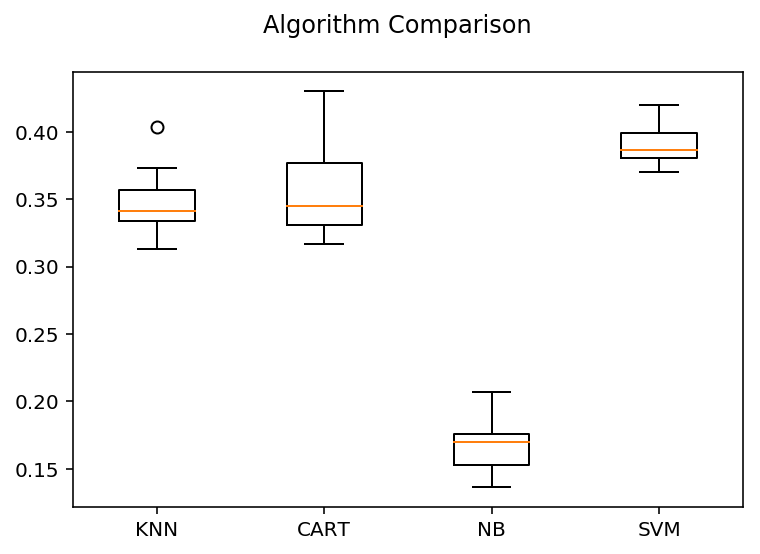

In [20]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()